In [2]:
import numpy as np
import pandas as pd
import os, glob
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import datetime as dt
import time

In [3]:
START_DATE = '2022-11-17'
PERIOD = 8
SOURCE = 'cc'
start = dt.datetime.strptime(START_DATE,'%Y-%m-%d')
dates = [(start + dt.timedelta(days=i)).date() for i in range(PERIOD)]
dates

[datetime.date(2022, 11, 17),
 datetime.date(2022, 11, 18),
 datetime.date(2022, 11, 19),
 datetime.date(2022, 11, 20),
 datetime.date(2022, 11, 21),
 datetime.date(2022, 11, 22),
 datetime.date(2022, 11, 23),
 datetime.date(2022, 11, 24)]

# Extracting anime name from website titles

- When uploaded, to optimize their traffic, website can added different element to make sure their keyword standout
- Manga title can be vietnamese, english or japanese (japanese pronoun)

In [75]:
## combine singular files to create raw dataset including only anime name and genres
# data = pd.DataFrame()
# for filename in glob.glob('anime_title_extraction/*_data_*.csv'):
#     source = re.search('([^_]*)_data',filename).group(1)
#     type = re.search('data_(.*).csv',filename).group(1)
#     t = pd.read_csv(filename)
#     t['source'] = source
#     t['type'] = type
#     data = pd.concat([data, t], axis = 0)
# data = data[['title1','title2','genre','source','type']].reset_index(drop=True)

# genre = data[['genre']].copy()
# titles = data['title2'].str.split('|', expand = True)
# df = pd.DataFrame()
# titles.columns = ['title' + str(t+2) for t in titles.columns]
# titles = pd.concat([data[['title1']],titles], axis=1)
# for i in titles.columns:
#     t = pd.concat([titles[[i]],genre],axis=1)
#     t = t.rename(columns={i:'title'})
#     t = t.dropna(how = 'any', axis = 0).reset_index(drop=True)
#     df = pd.concat([df,t], axis = 0).reset_index(drop=True)
# df.to_csv('anime_raw.csv', index=False)



df = pd.read_csv('anime_raw.csv')
df.head(5)

,title,genre
0,Naruto Shippuuden,"['hành động', 'hài hước', 'shounen', 'super po..."
1,Fairy Tail,"['hành động', 'hài hước', 'phiêu lưu', 'phép t..."
2,Vua Hải Tặc,"['hành động', 'hài hước', 'phiêu lưu', 'drama'..."
3,Black Clover,"['hành động', 'hài hước', 'phép thuật', 'shoun..."
4,Boruto: Naruto Next Generations,"['hành động', 'hài hước', 'shounen', 'super po..."


In [76]:
# remove white space
df['title_clean'] = df['title'].str.strip().str.replace('\s+',' ',regex=True).str.lower().replace({np.NaN:None})

# remove special characters
df['remove1'] = df['title_clean'].str.replace('([ -]+?[\[\(].*[\]\)] ?)','', regex = True)
df['remove2'] = df['remove1'].str.replace('([\\\/\?\"\:\!\~\#\$\%\^&\*\.\,\∬\;\>\<\+\°\◯\♪]{1,3})',' ', regex=True).str.replace('( -[ $]?)','-',regex=True).str.replace('\s+',' ',regex=True)

# remove keywords within the string
df['remove3'] = df['remove2'].str.replace('((?:^| )?(?:(?:the )?(?: new|first|final|second) (?:ss|season|phần|episode|part|series|chapter|mùa)|(?:new )?(?:ss|season|phần|episode|part|series|chapter|mùa) ?\d{1,2}(?:st|nd|rd|th)?(?:[ -]\d)*|(?:new )? \d(?:st|nd|rd|th)? (?:ss|season|phần|episode|part|series|chapter|mùa)))','', regex=True)

## remove keywords at the end of string
df['remove4'] = df['remove3'].str.replace('( uncensor| bd| vietsub| ova)$','', regex=True).str.strip()

## remove keywords with digits
df['remove5'] = df['remove4'].str.replace('((?: movie |series )(?:\d+\-)?\d+$|\d*[^\w]\d{1,2}$)','', regex=True) 

df.sample(n=5)

,title,genre,title_clean,remove1,remove2,remove3,remove4,remove5
1972,Tachibanakan Triangle,"['hài hước', 'ecchi', 'shoujo', 'shoujo ai']",tachibanakan triangle,tachibanakan triangle,tachibanakan triangle,tachibanakan triangle,tachibanakan triangle,tachibanakan triangle
2646,Sukitte Ii na yo,"['học đường', 'tình yêu', 'shoujo']",sukitte ii na yo,sukitte ii na yo,sukitte ii na yo,sukitte ii na yo,sukitte ii na yo,sukitte ii na yo
3961,Mo Dao Zu Shi,['hoạt hình trung quốc'],mo dao zu shi,mo dao zu shi,mo dao zu shi,mo dao zu shi,mo dao zu shi,mo dao zu shi
5995,A Peephole,"['hài hước', 'ecchi', 'drama']",a peephole,a peephole,a peephole,a peephole,a peephole,a peephole
1775,Code Geass: Hangyaku no Lelouch III - Oudou,"['hành động', 'mecha', 'học đường', 'viễn tưởn...",code geass: hangyaku no lelouch iii - oudou,code geass: hangyaku no lelouch iii - oudou,code geass hangyaku no lelouch iii-oudou,code geass hangyaku no lelouch iii-oudou,code geass hangyaku no lelouch iii-oudou,code geass hangyaku no lelouch iii-oudou


In [77]:
# some titles repeated themselved (Eg: Gaworare ss1, Gaworare ss2), let try to remove those redundancy to improve later matching

potential_titles = df[df['title'].fillna('').str.contains(',')][['remove1']].reset_index(drop=True)
potential_titles = potential_titles.drop_duplicates().reset_index(drop=True)
t = potential_titles['remove1'].str.split(',', expand = True)
for col in t.columns:
    t[col] = t[col].str.replace('([\\\/\?\"\:\!\~\#\$\%\^&\*\.\,\∬\;\>\<\+\°\◯\♪]{1,3})\-',' ', regex=True).str.replace('( -[ $]?)','-',regex=True).str.replace('\s+',' ',regex=True)
    t[col] = t[col].str.replace('((?:^| )?(?:(?:the )?(?: new|first|final|second) (?:ss|season|phần|episode|part|series|chapter|mùa)|(?:new )?(?:ss|season|phần|episode|part|series|chapter|mùa) ?\d{1,2}(?:st|nd|rd|th)?(?:[ -]\d)*|(?:new )? \d(?:st|nd|rd|th)? (?:ss|season|phần|episode|part|series|chapter|mùa)))','', regex=True)
    t[col] = t[col].str.replace('( uncensor| bd)$','', regex=True).str.strip()
    t[col] = t[col].str.replace('((?: movie |series )(?:\d+\-)?\d+$|\d*[^\w]\d{1,2}$)','', regex=True) 
t.combine = None
for row in t.itertuples():
    array_t=[]
    for i in range(1,7):
        if (not pd.isnull(row[i])) & (row[i] not in array_t):
            array_t.append(row[i])
    t.at[row[0],'combine'] = ' '.join(array_t)
potential_titles = pd.concat([potential_titles,t[['combine']]], axis=1)

df = pd.merge(df, potential_titles, how = 'left', on ='remove1')
df['remove6'] = df['combine'].fillna(df['remove5'])
df.drop(columns='combine', inplace=True)
potential_titles.sample(n=5)

,remove1,combine
274,the demon slayer: kimetsu no yaiba mugen train...,the demon slayer: kimetsu no yaiba mugen train...
29,"kanojo, okarishimasu 2nd season",kanojo okarishimasu
130,ms. corporate slave wants to be healed by a lo...,ms. corporate slave wants to be healed by a lo...
182,"by the grace of the gods, the man picked up by...",by the grace of the gods the man picked up by ...
31,"yondemasu yo, azazel-san z",yondemasu yo azazel-san z


In [78]:
## remove other stopwords
df['remove7'] = df['remove6'].str.replace(f'((?: |^)(?:the film|the movie|live action|bd|blu-ray|bluray|the series|the animation)(?: |$|-))','', regex=True)
## remove year of release
df['remove8'] = df['remove7'].str.replace('((?:20|19)\d\d)','', regex=True)
df[['title','remove6','remove7','remove8']].sample(n=20)

,title,remove6,remove7,remove8
6533,Akame ga Kiru! [Bluray],akame ga kiru,akame ga kiru,akame ga kiru
5187,"DanMachi 2nd Season, Is It Wrong That I Want t...",danmachi is it wrong that i want to meet you i...,danmachi is it wrong that i want to meet you i...,danmachi is it wrong that i want to meet you i...
396,Darwin’s Game,darwin’s game,darwin’s game,darwin’s game
3552,Date A Live: Mayuri Judgement,date a live mayuri judgement,date a live mayuri judgement,date a live mayuri judgement
1390,Attack on Titan Final Season,attack on titan,attack on titan,attack on titan
768,Nàng Nổi Loạn X Chàng Thợ May,nàng nổi loạn x chàng thợ may,nàng nổi loạn x chàng thợ may,nàng nổi loạn x chàng thợ may
4746,Cupid's Chocolates,cupid's chocolates,cupid's chocolates,cupid's chocolates
5846,Naka no Hito Genome [Jikkyouchuu],naka no hito genome,naka no hito genome,naka no hito genome
3180,Học Viện Anh Hùng Phần 1,học viện anh hùng,học viện anh hùng,học viện anh hùng
4755,Shinigami Bocchan to Kuro Maid,shinigami bocchan to kuro maid,shinigami bocchan to kuro maid,shinigami bocchan to kuro maid


In [79]:
df['final'] = np.where(df['remove8'].str.len()<=5, df['title_clean'], df['remove8'])
df['final'].nunique()

3436

In [80]:
df[['title','genre','final']].to_csv('final_title.csv',index=False)

# Grading match
- Finding search queries that match anime titles
- The way users find something can be very different with the title which required customed cleaning

In [14]:
# list of qualified title
title_list_o = pd.read_csv('final_title.csv')
title_list_o = title_list_o[~title_list_o['final'].isna()].reset_index(drop=True)
title_list = title_list_o['final'].unique().tolist()
len(title_list)


3435

In [71]:
# list of sample search querise from singular files
search_data = pd.DataFrame()
for d in dates:
    t = pd.read_csv(f'search_data_extraction/{SOURCE}_{d}_{d}.csv')
    search_data = pd.concat([search_data,t], axis=0)
search_data.to_csv(f'search_raw_{dates[0]}_{dates[-1]}.csv', index=False)

search_data = pd.read_csv(f'search_raw_{dates[0]}_{dates[-1]}.csv')
queries = search_data[['reqid','query']].copy()
queries.head(5)


,reqid,query
0,b'OW9m9KM4',thời tiết đồng nai
1,b'XeRlqBzd',gmail đăng nhập
2,b'wq53mD1b',instagram
3,b'BMWWk8GK',nhật bản vs canada
4,b'uaH5YDp4',Lịch thi đấu La Liga


In [45]:
#  remove white space and special character
queries['clean_query'] = queries['query'].str.replace('\s+',' ',regex=True).str.strip().str.lower().replace({np.NaN:None})
queries['clean_query'] = queries['clean_query'].str.replace('([ -]+?[\[\(].*[\]\)] ?)','', regex = True)
queries['clean_query'] = queries['clean_query'].str.replace('([\\\/\?\"\:\!\~\#\$\%\^&\*\.\,\∬\;\>\<\+\°\◯\♪\|]{1,3})',' ', regex=True).str.replace('( -[ $]?)','-',regex=True).str.replace('\s+',' ',regex=True)

# remove stopword1 within queries
queries['keyword_point'] = np.where(queries['clean_query'].str.contains('(?:^| )?(?:(?:the )?(?: new|first|final|second) (?:ss|season|phần|episode|part|series|chapter|mùa)|(?:new )?(?:ss|season|ph[ầa]n|episode|part|series|chapter|m[ùa]a|t[ậaâ]p|chap|ep) ?\d+(?:st|nd|rd|th)?(?:[ -]\d)*|(?:new )? \d(?:st|nd|rd|th)? (?:ss|season|phần|episode|part|series|chapter|mùa|tập|chap))', regex=True),1,0)
queries['clean_query'] = queries['clean_query'].str.replace('((?:^| )?(?:(?:the )?(?: new|first|final|second) (?:ss|season|phần|episode|part|series|chapter|mùa)|(?:new )?(?:ss|season|ph[ầa]n|episode|part|series|chapter|m[ùa]a|t[ậaâ]p|chap|ep) ?\d+(?:st|nd|rd|th)?(?:[ -]\d)*|(?:new )? \d(?:st|nd|rd|th)? (?:ss|season|phần|episode|part|series|chapter|mùa|tập|chap)))',' ', regex=True).str.replace('\s+',' ',regex=True).str.strip()
queries['clean_query'] = queries['clean_query'].str.replace('((?:^| |-)?(?:(?:ss|season|phần|episode|part|series|chapter|m[ùa]a|t[ậa]p|chap)(?: dài| ngắn| cu[ốo]i)|(?:dài |ngắn ) (?:ss|season|ph[ầa]n|episode|part|series|chapter|m[ùa]a|t[ậa]p|chap)))',' ', regex=True).str.replace('\s+',' ',regex=True).str.strip()

# remove stopword2 with digits
queries['keyword_point'] = np.where(queries['clean_query'].str.contains('(?: movie |series )(?:\d+\-)?\d+$', regex=True),queries['keyword_point'] + 1 ,queries['keyword_point'])
queries['clean_query'] = queries['clean_query'].str.replace('((?: movie |series )(?:\d+\-)?\d+$)','', regex=True)


# remove website address
queries['keyword_point'] = np.where(queries['clean_query'].str.contains('netflix|fpt.?play|phim.?moi|subnhanh|bilibili|anime\w*|vuighe|h[eẻ]nt[aả]i|manga|ani4u|anivn|dautay.tv|zoro.to|phimhoathinh|hhhkungfu|myanime|\bova\b', regex=True),queries['keyword_point'] + 2 ,queries['keyword_point'])
queries['clean_query'] = queries['clean_query'].str.replace('((?:^| |-)(?:netflix|fpt.?play|phim.?moi|h[eẻ]nt[aả]i\w*|subnhanh|bilibili|anime\w*|vuighe|ani4u|anivn|dautay.tv|zoro.to|phimhoathinh|hhhkungfu|myanime)\.?(?:com|net|biz|vn)?)',' ', regex=True).str.replace('\s+',' ',regex=True).str.strip()

# remove some other stopwords
queries['clean_query'] = queries['clean_query'].str.replace('((?:^| |-)(?:thuy[ếe]t minh|ph[ụu] [đd][ềe]|l[ồo]ng ti[ếe]ng|vietsub|ho[ạa]t h[ìi]nh|(?:xem )?phim[^\w]|(?:20|19)\d\d|(?:full)? hd|1080p?|ova|mới nhất|trung qu[ốo]c|nh[ậa]t b[aả]n|h[aà]n qu[ốo]c|(?:[aâ]u)? m[ỹĩy]|hay nhất|manga|xem|tải|download|sex|h[eẻ]nt[aả]i|(?:đ[ọo]c )?truy[ệe]n[^\w](?:tranh)?|nhạc|ost|tr[ọo]n b[ộo]|nude))',' ', regex=True).str.replace('\s+',' ',regex=True).str.strip()
queries['keyword_point'] = np.where(queries['clean_query'].str.contains('(?:xem)? phim|thuy[ếe]t minh|ph[ụu] [đd][ềe]|l[ồo]ng ti[ếe]ng|vietsub|ho[ạa]t h[ìi]nh|(?:xem )?phim[^\w]|blue.?ray|(?:full)? hd|1080|mới nhất', regex=True),queries['keyword_point'] + 0.5 ,queries['keyword_point'])

# remove some other stopwords
queries['keyword_point'] = np.where(queries['clean_query'].str.contains(f'(?:(?: |^)(?:the film|the movie|live action|bd|blu-ray|bluray|the series|the animation)(?: |$|-))', regex=True),queries['keyword_point'] + 1 ,queries['keyword_point'])
queries['clean_query'] = queries['clean_query'].str.replace(f'((?: |^)(?:the film|the movie|live action|bd|blu-ray|bluray|the series|the animation)(?: |$|-))','', regex=True)

queries.query('keyword_point > 0')[['query','clean_query','keyword_point']].sample(n=20)

,query,clean_query,keyword_point
6850,jav hd,jav hd,0.5
4405,Hentaiz,,2.0
7498,ass pussyfuck amateur teen purple bitch anime ...,ass pussyfuck amateur teen purple bitch,2.0
4231,phimmoi,,2.0
5730,phimmoi,,2.0
983,Hentai,,2.0
8432,sex bondage anime,bondage,2.0
3586,"giải toán hình 8 bài 6,7 tập 2",giải toán hình 8 bài 6 2,1.0
7005,Age of Empires II: HD Edition,age of empires ii hd edition,0.5
8394,hentai cube,cube,2.0


In [53]:
# give penalty score for queries that are too long, normalize the scores to make sure it's compatiple with keyword score

queries['length'] = queries['clean_query'].str.len()
result_percentile = queries.sort_values('length').copy()
result_percentile = result_percentile.groupby('length')['query'].count().reset_index(name='sum')
result_percentile['sum'] = result_percentile['sum'].cumsum()
total_query = result_percentile.sort_values('sum',ascending=False).reset_index(drop=True).loc[0,'sum']
result_percentile['quantile'] = result_percentile['sum']/total_query
result_percentile
mean_length = queries['length'].mean()

Q1 = queries['length'].quantile(0.25)
Q3 = queries['length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q1, Q3, IQR ,lower_bound, upper_bound)


queries['penalty'] = queries.apply(lambda x: abs(x.length-mean_length) if x.length<upper_bound else abs(x.length-upper_bound),axis=1)
min_p = queries['penalty'].min()
max_p = queries['penalty'].max()
queries['noz_p'] = (queries['penalty']-min_p)/(max_p-min_p)

queries.to_csv('cleaned_queries.csv', index=False)

7.0 25.0 18.0 -20.0 52.0


In [48]:
# make sure queries are unique
queries_nor = queries.copy()
queries_nor['id'] = queries_nor[['query', 'reqid','keyword_point']].values.tolist()
queries_nor = queries_nor.groupby('clean_query').agg({'keyword_point':'max','id':lambda x: np.array(x)}).reset_index()
queries_nor = queries_nor[queries_nor['clean_query']!=''].sort_values('keyword_point', ascending=False).reset_index(drop=True)
queries_nor.sample(n=20, weights='keyword_point')

,clean_query,keyword_point,id
401,wiki adventures,2.0,"[[wiki anime adventures, b'dqRCB2Qj', 2.0]]"
309,chainsaw man,2.0,"[[truyện chainsaw man, b'2ClictRa', 0.0], [cha..."
140,ảnh,2.0,"[[ảnh sex, b'd0NYqGAO', 0.0], [ảnh anime, b'4N..."
363,kisaragi gunma nhentai,2.0,"[[kisaragi gunma nhentai, b'Ex5ZZ1zX', 2.0]]"
502,đáp án của bài 54 vở bài tập toán lớp 1,1.0,[[đáp án của bài 54 vở bài tập toán lớp 5 tập ...
353,cách cài hình trên visual studio code,2.0,"[[cách cài hình anime trên visual studio code,..."
725,bài rồng rắn lên mây lớp 1 sách kết nối,1.0,[[Bài Rồng rắn lên mây lớp 2 tập 1 sách kết nố...
736,bài 4 1 sbt trang 162 toán 1,1.0,"[[bài 4.1 sbt trang 162 toán 8 tập 1, b'qnBMc6..."
949,tao muốn trở thành chúa tể bóng tối,1.0,"[[tao muốn trở thành chúa tể bóng tối, b'IqAWy..."
210,free pic,2.0,"[[hentai free pic, b'ZvhDBnSG', 2.0]]"


In [49]:
queries_nor.groupby('keyword_point')['keyword_point'].count()

keyword_point
0.0    42183
0.5      166
1.0      492
1.5        7
2.0      452
2.5        4
3.0        7
Name: keyword_point, dtype: int64

In [118]:
## grading search queries and anime titles match using ratio and token set ratio and save it to anime search count folder

queries_list = queries_nor['clean_query'].values.tolist()
result = []
i = 0
for q in queries_list:
    top_r1 = 0
    top_title1 = ''
    top_r2 = 1
    top_title2 = ''
    top_r3 = 2
    top_title3 = ''
    for t in title_list:
        # try:
            _r1 = fuzz.ratio(q,t)
            if _r1 > top_r1:
                top_r1 = _r1
                top_title1 = t

            _r2 = fuzz.token_set_ratio(q,t)
            if _r2 > top_r2:
                top_r2 = _r2
                top_title2 = t
        # except:
            # print(t)
    i += 1
    print(f'done {i}')
    result.append([q,top_r1,top_title1,top_r2,top_title2])


result = pd.DataFrame(data=result,columns=['clean_query','top_r1','top_title1','top_r2','top_title2'])
result['sum'] = result['top_r1']+result['top_r2']
result['length'] = result['clean_query'].str.len()
result = result.sort_values('top_r1',ascending=False).reset_index(drop=True)
result['clean_query'] = result['clean_query'].fillna(result['clean_query'].str.strip().str.replace('\s+',' ',regex=True).str.lower().str.strip())
if not os.path.isfile(f'anime_search_detail/RESULT1_{SOURCE}_{START_DATE}_{dates[-1]}.csv'):
    result.to_csv(f'anime_search_detail/RESULT1_{SOURCE}_{START_DATE}_{dates[-1]}.csv',index=False)

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
done 100
done 101
done 102
done 103
done 104
done 105
done 106
done 107
done 108
done 109
done 110
done 111
done 112
done 113
done 114
done 115
done 116
done 117
done 118
done 119
done 120
done 121
done 122
done 123
d

# Combine data
- combine search - name - genres data
- decide the threshold for the above grading, higher the grade, the more likely the query would be anime

In [83]:
result = pd.read_csv(f'anime_search_detail/RESULT1_{SOURCE}_{START_DATE}_{dates[-1]}.csv')
queries = pd.read_csv('cleaned_queries.csv')
search_data = pd.read_csv(f'search_raw_{dates[0]}_{dates[-1]}.csv')


In [84]:
## check dup columns
print(result.columns)
# ['clean_query', 'top_r1', 'top_title1', 'top_r2', 'top_title2', 'sum']
print(queries.columns)
# ['reqid', 'query', 'clean_query', 'keyword_point', 'length','penalty', 'noz_p']
print(search_data.columns)
# ['reqid', 'user_id', 'device', 'query', 'probabilities', 'category_ids','category_name', 'date']

Index(['clean_query', 'top_r1', 'top_title1', 'top_r2', 'top_title2', 'sum',
       'length'],
      dtype='object')
Index(['reqid', 'query', 'clean_query', 'keyword_point', 'length', 'penalty',
       'noz_p'],
      dtype='object')
Index(['reqid', 'user_id', 'device', 'query', 'probabilities', 'category_ids',
       'category_name', 'date'],
      dtype='object')


In [85]:
regex_tone = re.compile(r'[àáảãạăắằẵặẳâầấậẫẩèéẹẻẽêềếệểễđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]')
stats = pd.merge(queries.drop(columns='query'),result.drop(columns='length'), how = 'left', on='clean_query')
stats = pd.merge(search_data,stats, how = 'left', on='reqid')
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73923 entries, 0 to 73922
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reqid          73923 non-null  object 
 1   user_id        73923 non-null  object 
 2   device         73923 non-null  object 
 3   query          73923 non-null  object 
 4   probabilities  73923 non-null  object 
 5   category_ids   73923 non-null  object 
 6   category_name  73923 non-null  object 
 7   date           73923 non-null  object 
 8   clean_query    72879 non-null  object 
 9   keyword_point  73923 non-null  float64
 10  length         73923 non-null  int64  
 11  penalty        73923 non-null  float64
 12  noz_p          73923 non-null  float64
 13  top_r1         72515 non-null  float64
 14  top_title1     72472 non-null  object 
 15  top_r2         72515 non-null  float64
 16  top_title2     72468 non-null  object 
 17  sum            72515 non-null  float64
dtypes: flo

In [86]:
stats['vn_query_flag'] = np.where(stats['clean_query'].fillna('').str.contains('[àáảãạăắằẵặẳâầấậẫẩèéẹẻẽêềếệểễđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]',regex=True), 1, 0)
stats['vn_title1_flag'] = np.where(stats['top_title1'].fillna('').str.contains('[àáảãạăắằẵặẳâầấậẫẩèéẹẻẽêềếệểễđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]',regex=True), 1, 0)
stats['vn_title2_flag'] = np.where(stats['top_title2'].fillna('').str.contains('[àáảãạăắằẵặẳâầấậẫẩèéẹẻẽêềếệểễđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]',regex=True), 1, 0)
stats['score1_adj'] = np.where((stats['clean_query'].str.len()<=15) & (stats['top_title1'].str.len()<=15) & (stats['top_r1'] < 85),0,stats['top_r1'])
stats['score1_adj'] = np.where((stats['vn_query_flag']==0) & (stats['vn_title1_flag']==1) & (stats['top_r1'] >= 70)& (stats['top_title1'].astype(str).str.len()/ stats['clean_query'].str.len() < 1.1) & (stats['top_title1'].astype(str).str.len()/ stats['clean_query'].fillna('').str.len() > 0.9),100,stats['score1_adj'])
stats['score2_adj'] = np.where((stats['top_title2'].str.len()/ stats['clean_query'].str.len() < 0.5) | (stats['top_title2'].str.len()/ stats['clean_query'].str.len() > 2),0,stats['top_r2'])
stats['score2_adj'] = np.where((stats['vn_query_flag']==1) & (stats['vn_title2_flag']==1) & (stats['sum'] < 170),0,stats['score2_adj'])
stats['score2_adj'] = np.where(stats['clean_query'].astype(str).str.contains('(?<! to )world cup|champions league', regex=True),0,stats['score2_adj'])


## other indicators
stats['manga_flag'] = np.where((stats['clean_query'].fillna('').str.contains('truy[ệe]n|manga|đọc',regex=True))&(stats['anime_flag']==1),1,0)
stats['weighted_score'] = stats['score1_adj']+stats['score2_adj']
stats['anime_flag'] = np.where(((stats.weighted_score >150)&(~stats['clean_query'].astype(str).str.contains('(?<! to )world cup|champions league', regex=True))) | (stats['keyword_point']>=2),1,0)
stats['adult_flag'] = np.where((stats['query'].str.lower().str.contains('se+x+|h[eẻê]n[- ]?t[aảâ]|ch[ịi]ch|địt|18|đụ|jav|nude',regex=True))&(stats['anime_flag']==1),1,0)
stats['game_flag'] = np.where((stats['clean_query'].fillna('').str.contains('game',regex=True))&(stats['anime_flag']==1)&(~stats['top_title1'].astype(str).str.contains('game')),1,0)

In [9]:
stats = stats.sort_values(['anime_flag','weighted_score'], ascending=False)[['query', 'category_name', 'date', 'clean_query', 'top_r1', 'top_title1', 
                                                                             'top_r2', 'top_title2', 'vn_query_flag', 'vn_title1_flag', 'vn_title2_flag',
                                                                             'score1_adj', 'score2_adj', 'weighted_score', 'anime_flag',
                                                                             'adult_flag', 'game_flag', 'manga_flag']].reset_index(drop=True)
stats.head(20)
stats.to_csv(f'anime_search_detail/RESULT2_{SOURCE}_{START_DATE}_{dates[-1]}.csv',index=False)

# EDA

In [21]:
import seaborn as sns

In [15]:
# stats = pd.read_csv(f'anime_search_detail/RESULT2_{SOURCE}_{START_DATE}_{dates[-1]}.csv')
stats.columns

Index(['query', 'category_name', 'date', 'clean_query', 'top_r1', 'top_title1',
       'top_r2', 'top_title2', 'vn_query_flag', 'vn_title1_flag',
       'vn_title2_flag', 'score1_adj', 'score2_adj', 'weighted_score',
       'anime_flag', 'adult_flag', 'game_flag', 'manga_flag'],
      dtype='object')

In [16]:
title_list_o = pd.read_csv('final_title.csv')
title_list_df = title_list_o[['final','genre']].drop_duplicates().reset_index(drop=True)
title_list_df['genre'] = title_list_df['genre'].str.replace('[\'\[\]]| (?=,)|(?<=,) ','',regex=True)
# title_list
title_list_df = title_list_df.groupby(['final'])['genre'].apply(lambda x: ','.join(x)).reset_index()
# title_list
from_array = ['kid','fantasy','shounen','super power','martial arts','romance','demons','xuyên không - chuyển kiếp','mystery','đang cập nhật','vampire','music','military','space','blu-ray','psychological']
to_array = ['kids','giả tưởng','shounen','siêu năng lực','võ thuật','tình yêu','ác quỷ','du hành thời gian','bỉ ẩn','','ma cà rồng','âm nhạc','quân đội','vũ trụ','','tâm lý']
def convert_to_arr(row):
    output = []
    for t in row['genre'].split(','):
        if (t in from_array):
            _i = from_array.index(t)
            tt = to_array[_i]
        else:
            tt = t
        
        if (tt not in output)&(tt != ''):
            output.append(tt)

    return list(output)
title_list_df['genre_arr'] = title_list_df.apply(convert_to_arr, axis=1)
title_list_df['genre'] = title_list_df.apply(lambda x: ', '.join(x['genre_arr']), axis=1)
title_list_df.columns=['top_title1','genre','genre_arr']
title_list_df['top_title2'] = title_list_df['top_title1']
title_list_df

,top_title1,genre,genre_arr,top_title2
0,07 ghost,"dementia, hành động, giả tưởng, phép thuật, sh...","[dementia, hành động, giả tưởng, phép thuật, s...",07 ghost
1,07-ghost,"hành động, giả tưởng, phép thuật, shoujo, quân...","[hành động, giả tưởng, phép thuật, shoujo, quâ...",07-ghost
2,100-man no inochi no ue ni ore wa tatteiru,"hành động, drama, shounen, giả tưởng, game, du...","[hành động, drama, shounen, giả tưởng, game, d...",100-man no inochi no ue ni ore wa tatteiru
3,11 eyes,"hành động, ecchi, siêu nhiên, siêu năng lực, h...","[hành động, ecchi, siêu nhiên, siêu năng lực, ...",11 eyes
4,11eyes,"hài hước, ecchi, siêu năng lực, siêu nhiên","[hài hước, ecchi, siêu năng lực, siêu nhiên]",11eyes
...,...,...,...,...
3430,银河之心,"hành động, viễn tưởng, hoạt hình trung quốc","[hành động, viễn tưởng, hoạt hình trung quốc]",银河之心
3431,魔入りました！入間くん,"hài hước, giả tưởng, du hành thời gian, mythol...","[hài hước, giả tưởng, du hành thời gian, mytho...",魔入りました！入間くん
3432,ａｉｋａ,"hành động, phiêu lưu, hài hước, viễn tưởng, ecchi","[hành động, phiêu lưu, hài hước, viễn tưởng, e...",ａｉｋａ
3433,ｃｌａｎｎａｄ 〜ａｆｔｅｒ ｓｔｏｒｙ〜 クラナド アフターストーリー,"đời thường, tình yêu, tragedy","[đời thường, tình yêu, tragedy]",ｃｌａｎｎａｄ 〜ａｆｔｅｒ ｓｔｏｒｙ〜 クラナド アフターストーリー


In [18]:
genres = pd.merge(stats[['query','clean_query','anime_flag','top_title1','top_title2']],title_list_df[['top_title1','genre','genre_arr']], how = 'left', on = 'top_title1')
genres = genres.rename(columns={'genre_arr':'genre_arr1','genre':'genre1'})
genres = pd.merge(genres,title_list_df[['top_title2','genre_arr']], how = 'left', on = 'top_title2')
genres = genres.rename(columns={'genre_arr':'genre_arr2','genre':'genre2'})
genres = genres[genres['anime_flag']==1].reset_index(drop=True)
genres

,query,clean_query,anime_flag,top_title1,top_title2,genre1,genre_arr1,genre_arr2
0,thế giới hoàn mỹ,thế giới hoàn mỹ,1,thế giới hoàn mỹ,thế giới hoàn mỹ,"hành động, viễn tưởng, hoạt hình trung quốc, g...","[hành động, viễn tưởng, hoạt hình trung quốc, ...","[hành động, viễn tưởng, hoạt hình trung quốc, ..."
1,nhất niệm vĩnh hằng,nhất niệm vĩnh hằng,1,nhất niệm vĩnh hằng,nhất niệm vĩnh hằng,"phiêu lưu, phép thuật, siêu nhiên, hoạt hình t...","[phiêu lưu, phép thuật, siêu nhiên, hoạt hình ...","[phiêu lưu, phép thuật, siêu nhiên, hoạt hình ..."
2,fairy tail tập 122,fairy tail,1,fairy tail,fairy tail,"hành động, hài hước, phiêu lưu, phép thuật, sh...","[hành động, hài hước, phiêu lưu, phép thuật, s...","[hành động, hài hước, phiêu lưu, phép thuật, s..."
3,thần mộ,thần mộ,1,thần mộ,thần mộ,"du hành thời gian, hoạt hình trung quốc","[du hành thời gian, hoạt hình trung quốc]","[du hành thời gian, hoạt hình trung quốc]"
4,one punch man,one punch man,1,one punch man,one punch man,"hành động, hài hước, viễn tưởng, seinen, siêu ...","[hành động, hài hước, viễn tưởng, seinen, siêu...","[hành động, hài hước, viễn tưởng, seinen, siêu..."
...,...,...,...,...,...,...,...,...
1611,hentai,NaN,1,NaN,NaN,NaN,NaN,NaN
1612,anime47,NaN,1,NaN,NaN,NaN,NaN,NaN
1613,hentaivn,NaN,1,NaN,NaN,NaN,NaN,NaN
1614,hentaiz,NaN,1,NaN,NaN,NaN,NaN,NaN


,genre1,genrs_group_count
40,hoạt hình trung quốc,73
221,"hành động, phiêu lưu, shounen",51
214,"hành động, phiêu lưu, hài hước, viễn tưởng, ecchi",24
154,"hành động, hài hước, phiêu lưu, drama, shounen...",24
178,"hành động, học đường, hài hước, ecchi, siêu nhiên",24
...,...,...
162,"hành động, hài hước, phiêu lưu, shounen, siêu ...",1
163,"hành động, hài hước, phép thuật, giả tưởng",1
166,"hành động, hài hước, seinen, siêu nhiên, ma cà...",1
167,"hành động, hài hước, shounen, lịch sử, giả tưở...",1


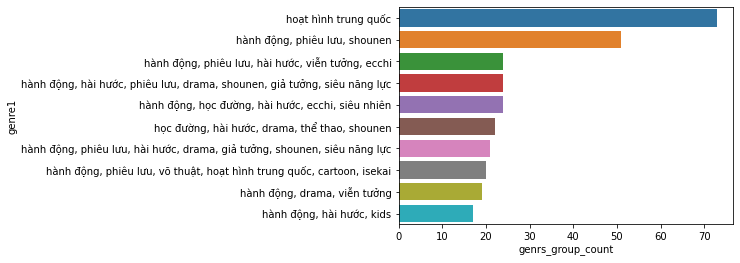

In [24]:
stats1 = genres['genre1'].explode().reset_index()
stats1 = stats1[~stats1['genre1'].isin(['đang cập nhật'])].groupby('genre1')['genre1'].count().reset_index(name='genrs_group_count').sort_values('genrs_group_count', ascending=False)
# stats1.to_csv('topten_gen_group.csv',index=False)
sns.barplot(data=stats1.head(10), x="genrs_group_count", y="genre1")
stats1

,genre,genre_count_single
0,hành động,583
1,hài hước,155
2,học đường,83
3,hoạt hình trung quốc,83
4,phiêu lưu,60
5,drama,40
6,thể thao,15
7,ecchi,11
8,kinh dị,10
9,giả tưởng,9


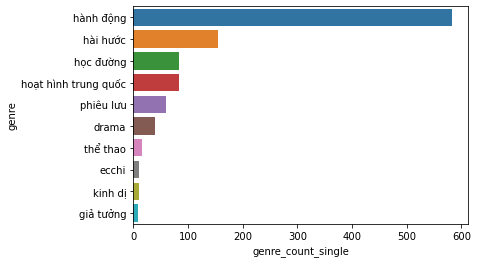

In [31]:
stats2 =  genres['genre1'].fillna('').str.extract('([^,]+)')
stats2.columns = ['genre']
stats2 = stats2.groupby('genre')['genre'].count().reset_index(name='genre_count_single').sort_values('genre_count_single', ascending=False).reset_index(drop=True)
sns.barplot(data=stats2.head(10), x="genre_count_single", y="genre")
stats2

In [32]:
stats3 = genres['genre_arr1'].explode().reset_index()
stats3 = stats3.groupby('genre_arr1')['genre_arr1'].count().reset_index(name='genres_count_all').sort_values('genres_count_all', ascending=False).reset_index(drop=True).head(12)
stats3['percent'] = stats3['genres_count_all']/genres['genre_arr1'].count()
stats3

,genre_arr1,genres_count_all,percent
0,hành động,627,0.575229
1,hài hước,484,0.444037
2,shounen,376,0.344954
3,phiêu lưu,363,0.333028
4,giả tưởng,311,0.285321
5,học đường,282,0.258716
6,drama,228,0.209174
7,siêu nhiên,197,0.180734
8,hoạt hình trung quốc,191,0.175229
9,tình yêu,182,0.166972
